# Implementation of Stand Alone Self Attention in Vision Models

![Stand Alone SA module](images/sasa.png)

In [1]:
from fastai.vision.all import *

In [2]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, classification_report

## Relative Self Attention Module

In [3]:
class RelativeSelfAttention(Module):
    def __init__(self, d_in, d_out, ks, groups, stride=1):
        self.n_c, self.ks, self.groups, self.stride = d_out, ks, groups, stride
        # linear transformation for queries, values and keys
        self.qx, self.kx, self.vx = [ConvLayer(d_in, d_out, ks=1, norm_type=None,
                                               act_cls=None) for _ in range(3)]
        # positional embeddings
        self.row_embeddings = nn.Parameter(torch.randn(d_out//2, ks))
        self.col_embeddings = nn.Parameter(torch.randn(d_out//2, ks))
        
    def calc_out_shape(self, inp_shape, pad):
        out_shape = [(sz + 2*pad - self.ks) // self.stride + 1 for sz in inp_shape]
        return out_shape
    
    def forward(self, x):
        query, keys, values = self.qx(x), self.kx(x), self.vx(x)
        
        pad = (self.ks -1) // 2
        
        # use unfold to extract the memory blocks and their associated queries
        query = F.unfold(query, kernel_size=1, stride=self.stride)
        keys = F.unfold(keys, kernel_size=self.ks, padding=pad, stride=self.stride)
        values = F.unfold(values, kernel_size=self.ks, padding=pad, stride=self.stride)
        
        
        # reshape and permute the dimensions into the appropriate format for matrix multiplication
        query = query.view(query.shape[0], self.groups, self.n_c//self.groups, -1, query.shape[-1]) # bs*G*C//G*1*N
        query = query.permute(0, 4, 1, 2, 3) # bs * N * G * C//G * 1
        keys = keys.view(keys.shape[0], self.groups, self.n_c//self.groups, -1, keys.shape[-1]) # bs*G*C//G*ks^2*N
        keys = keys.permute(0, 4, 1, 2, 3) # bs * N * G * C//G * ks^2
        values = values.view(values.shape[0], self.groups, self.n_c//self.groups, -1, values.shape[-1]) # bs*G*C//G*ks^2*N
        values = values.permute(0, 4, 1, 2, 3) # bs * N * G * C//G * ks^2
        
        # get positional embeddings
        row_embeddings = self.row_embeddings.unsqueeze(-1).expand(-1, -1, self.ks)
        col_embeddings = self.col_embeddings.unsqueeze(-2).expand(-1, self.ks, -1)
        
        embeddings = torch.cat((row_embeddings, col_embeddings)).view(self.groups,
                                self.n_c//self.groups, -1) # G * C//G * ks^2
        # add empty dimensions to match the shape of keys
        embeddings = embeddings[None, None, -1] # 1 * 1 * G * C//G * ks^2
        
        # compute attention map
        att_map = F.softmax(torch.matmul(query.transpose(-2,-1), keys+embeddings).contiguous(), dim=-1)
        # compute final output
        out = torch.matmul(att_map, values.transpose(-2,-1)).contiguous().permute(0, 2, 3, 4, 1)
        
        return out.view(out.shape[0], self.n_c, *self.calc_out_shape(x.shape[-2:], pad)).contiguous()

## Define helper functions and modules

In [4]:
def resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], stride=2 if i==0 else 1)
         for i in range(len(sizes) - 1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [5]:
def bottleneck(ni, nf, stride):
    if stride==1:
        layers = [ConvLayer(ni, nf//4, ks=1),
              RelativeSelfAttention(nf//4, nf//4, ks=7, groups=8),
              ConvLayer(nf//4, nf, ks=1, act_cls=None, norm_type=NormType.BatchZero)]
    else:
        layers = [ConvLayer(ni, nf//4, ks=1),
              RelativeSelfAttention(nf//4, nf//4, ks=7, groups=8),
              nn.AvgPool2d(2, ceil_mode=True),
              ConvLayer(nf//4, nf, ks=1, act_cls=None, norm_type=NormType.BatchZero)]
    
    return nn.Sequential(*layers)

In [6]:
class ResNetBlock(Module):
    def __init__(self, ni, nf, stride, sa, expansion=1):
        self.botl = bottleneck(ni, nf, stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        
    def forward(self, x):
        return F.relu(self.botl(x) + self.idconv(self.pool(x)))

## Define ResNet module

In [7]:
class xResNet(nn.Sequential):
    def __init__(self, channels, n_out, blocks, sa=True, expansion=1):
        stem = resnet_stem(channels, 32, 32, 64)
        self.group_sizes = [64, 64, 128, 256, 512]
        for i in range(1, len(self.group_sizes)): 
            self.group_sizes[i] *= expansion
        groups = [self._make_group(idx, n_blocks, sa=sa if idx==0 else False) 
                      for idx, n_blocks in enumerate(blocks)]

        super().__init__(*stem, *groups,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.group_sizes[-1], n_out))
        
    def _make_group(self, idx, n_blocks, sa):
        stride = 1 if idx==1 else 2
        ni, nf = self.group_sizes[idx], self.group_sizes[idx+1]
        return nn.Sequential(*[
            ResNetBlock(ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                        sa=sa if i==n_blocks-1 else False)
             for i in range(n_blocks)
        ])

## Get the data

In [8]:
path = Path('data/')
Path.BASE_PATH = path
path.ls()

(#2) [Path('.ipynb_checkpoints'),Path('cell_images')]

In [9]:
imgs = get_image_files(path/'cell_images/cell_images')

In [10]:
img_sizes = L([Image.open(img).shape for img in imgs])

In [11]:
img_sizes

(#27558) [(151, 145),(112, 139),(133, 115),(148, 142),(109, 115),(160, 127),(136, 133),(160, 151),(136, 148),(145, 133)...]

In [12]:
h = []
w = []

for i in img_sizes:
    h.append(i[0])
    w.append(i[1])

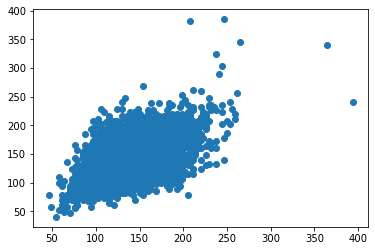

In [13]:
plt.scatter(w, h)

In [14]:
def get_y(o):
    return [o.parent.name]

In [15]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(seed=42),
                   get_y=get_y,
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(flip_vert=True, max_zoom=1.2, max_warp=0), Normalize()])

In [16]:
dls = dblock.dataloaders(path/'cell_images/cell_images', bs=64)

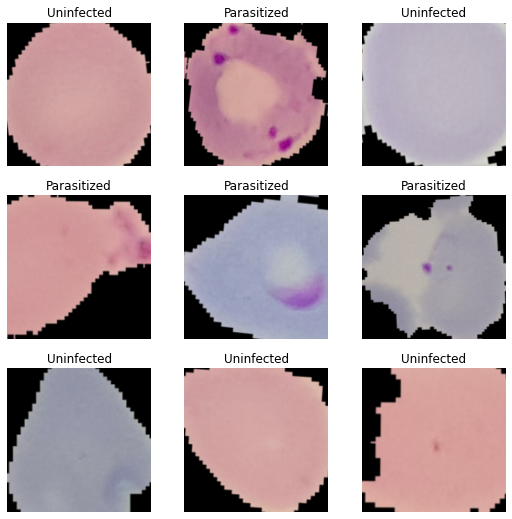

In [17]:
dls.show_batch()






# Learner

In [18]:
dls.c

2

In [17]:
model = xResNet(3, dls.c, [2,2,2,2])

In [18]:
learn= Learner(dls, model, metrics=partial(accuracy_multi, thresh=0.5))

In [21]:
learn.dls.vocab

['Parasitized', 'Uninfected']

In [22]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [24]:
learn.summary()

xResNet (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 112 x 112  864        True      
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 32 x 112 x 112  9,216      True      
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 64 x 112 x 112  18,432     True      
____________________________________________________

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.05754399299621582)

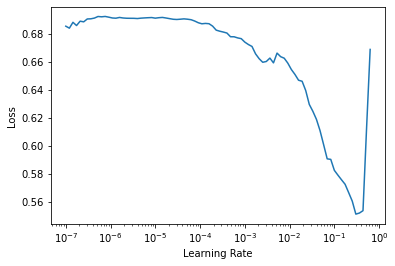

In [25]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.519590,0.440808,0.836690,02:27
1,0.197382,0.142545,0.954001,02:27
2,0.187798,0.126769,0.956995,02:26
3,0.181869,0.220887,0.925331,02:26
4,0.168829,0.124162,0.958356,02:26
5,0.164147,0.146138,0.947559,02:26
6,0.159597,0.113670,0.959173,02:26
7,0.144455,0.115224,0.960896,02:26
8,0.142075,0.105054,0.963709,02:26
9,0.146214,0.102227,0.965614,02:26


In [27]:
learn.export()

In [28]:
learn.save('r18_pool_before')

Path('models/r18_pool_before.pth')

In [19]:
learn.load('r18_pool_before');

**find the best threshold**

In [20]:
preds,targs = learn.get_preds()

In [21]:
accuracy_multi(preds, targs, thresh=0.5, sigmoid=False)

tensor(0.9692)

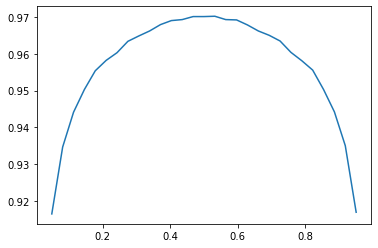

In [26]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

Interpretation

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

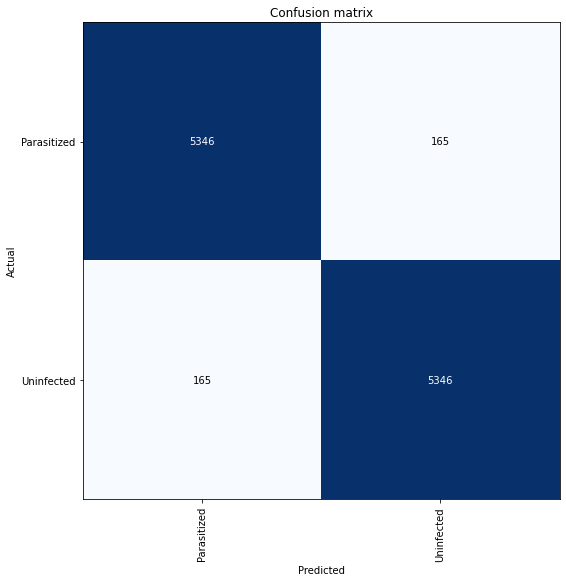

In [34]:
interp.plot_confusion_matrix(figsize=(10, 8))

In [35]:
preds, y_true=learn.get_preds()
y_true.shape, preds.shape

(torch.Size([5511, 2]), torch.Size([5511, 2]))

In [36]:
preds = np.argmax(preds.numpy(), axis=-1)
y_true = np.argmax(y_true.numpy(), axis=-1)
y_true.shape, preds.shape

((5511,), (5511,))

In [37]:
classes = list(dls.vocab)
report = classification_report(y_true, preds, target_names=classes)
print(report)

              precision    recall  f1-score   support

 Parasitized       0.98      0.96      0.97      2725
  Uninfected       0.96      0.98      0.97      2786

    accuracy                           0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511



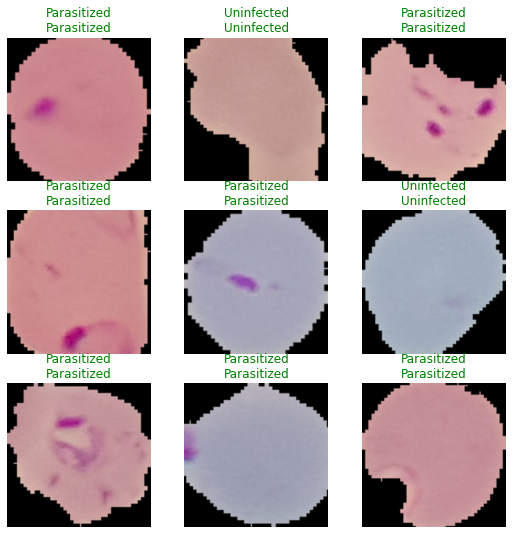

In [38]:
learn.show_results()

## Compare with pure convolutional ResNets

In [15]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

In [16]:
learn.summary()

Sequential (Input shape: ['32 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          32 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 32 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               32 x 64 x 56 x 56    36,864     False     
________________________________________________________________
BatchNorm2d          32 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 32 x 64 x 56 x 56    0          False     
_________________________________________________

## Thresh on raw logits

In [22]:
xb, yb = first(dls.valid)

In [23]:
xb.shape, yb.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 2]))

In [24]:
raw_logits = learn.model(xb)

In [25]:
raw_logits.shape

torch.Size([64, 2])

In [26]:
raw_logits[0]

tensor([ 10.6596, -10.6547], device='cuda:0', grad_fn=<SelectBackward>)

In [27]:
raw_logits

tensor([[ 10.6596, -10.6547],
        [ -7.6221,   7.6410],
        [ -3.4401,   3.4410],
        [  7.9003,  -7.8736],
        [ -7.7308,   7.7339],
        [ -3.4527,   3.4559],
        [ -4.7093,   4.6988],
        [ 13.8226, -13.8326],
        [ 11.3260, -11.3160],
        [ 16.1366, -16.1166],
        [  4.3877,  -4.3905],
        [  2.6922,  -2.6666],
        [  2.4929,  -2.5004],
        [  6.0565,  -6.0410],
        [  4.4624,  -4.4467],
        [ -4.6840,   4.6898],
        [ -4.4798,   4.4936],
        [ 12.7271, -12.6794],
        [ 10.2989, -10.3067],
        [ -5.9568,   5.9767],
        [ -2.8753,   2.8856],
        [  8.5883,  -8.5481],
        [ -3.9648,   3.9845],
        [  8.2438,  -8.2367],
        [  9.5853,  -9.5640],
        [ -6.4540,   6.4745],
        [  5.8224,  -5.8488],
        [ -3.6022,   3.6354],
        [  7.5829,  -7.5386],
        [  7.7319,  -7.7176],
        [ -5.9747,   5.9735],
        [ -5.6231,   5.5860],
        [  7.1711,  -7.1085],
        [ 

In [28]:
F.softmax(raw_logits, dim=-1)

tensor([[1.0000e+00, 5.5379e-10],
        [2.3515e-07, 1.0000e+00],
        [1.0260e-03, 9.9897e-01],
        [1.0000e+00, 1.4110e-07],
        [1.9221e-07, 1.0000e+00],
        [9.9817e-04, 9.9900e-01],
        [8.2048e-05, 9.9992e-01],
        [1.0000e+00, 9.7606e-13],
        [1.0000e+00, 1.4680e-10],
        [1.0000e+00, 9.8317e-15],
        [9.9985e-01, 1.5403e-04],
        [9.9532e-01, 4.6845e-03],
        [9.9326e-01, 6.7371e-03],
        [9.9999e-01, 5.5731e-06],
        [9.9986e-01, 1.3514e-04],
        [8.4911e-05, 9.9992e-01],
        [1.2672e-04, 9.9987e-01],
        [1.0000e+00, 9.2491e-12],
        [1.0000e+00, 1.1249e-09],
        [6.5665e-06, 9.9999e-01],
        [3.1383e-03, 9.9686e-01],
        [1.0000e+00, 3.6120e-08],
        [3.5280e-04, 9.9965e-01],
        [1.0000e+00, 6.9599e-08],
        [1.0000e+00, 4.8259e-09],
        [2.4280e-06, 1.0000e+00],
        [9.9999e-01, 8.5366e-06],
        [7.1855e-04, 9.9928e-01],
        [1.0000e+00, 2.7090e-07],
        [1.000